Importing Necessary Libraries for LSTM based model

In [ ]:
import re
import pandas as pd
import numpy as np
import nltk

In [ ]:
from nltk.corpus import stopwords

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

Uploading Raw Dataset - IMDB dataset containing 50,000 movie reviews classified as positive or negative

In [ ]:
from google.colab import files
data = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [ ]:
data = pd.read_csv('IMDB Dataset.csv')

In [ ]:
data.head()

,Unnamed: 0,sentiment,Reviews
0,0,positive,one reviewer mentioned watching 1 oz episode h...
1,1,positive,wonderful little production br br filming tech...
2,2,positive,thought wonderful way spend time hot summer we...
3,3,negative,basically family little boy jake think zombie ...
4,4,positive,petter mattei love time money visually stunnin...


Data Preprocessing 
1. Removing html tags, urls
2. Lemmatizing the data using WordNetLemmatizer

In [ ]:
def clean_data(feature):
    feature = re.sub('','',feature)
    feature = re.sub('https?://','', feature)
    feature = re.sub('<[^<]+[a-zA-Z]?>', '', feature)
    return feature

data['review'] = data['review'].apply(clean_data)

In [ ]:
def lemmatize_data(rev):
   
    rev = rev.lower()
    rev = rev.split()
    rev = [lemmatizer.lemmatize(word) for word in rev if word not in set(stopwords.words('english'))]
    rev = ' '.join(rev)
       
    return rev

#data['review'] = data['review'].apply(lemmatize_data)

In [ ]:
li = []
i = 0
for r in data['review']:
    s = lemmatize_data(r)
    li.append(s)
    i = i+1
    if i % 5000 == 0:            #only to track the progress
        print(i)
    
    
data['Reviews'] = li

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000


In [ ]:
data

,review,sentiment,Reviews
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching 1 oz episode h...
1,A wonderful little production. The filming tec...,positive,wonderful little production. filming technique...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there's family little boy (jake) thi...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"petter mattei's ""love time money"" visually stu..."
...,...,...,...
49995,I thought this movie did a down right good job...,positive,thought movie right good job. creative origina...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"bad plot, bad dialogue, bad acting, idiotic di..."
49997,I am a Catholic taught in parochial elementary...,negative,catholic taught parochial elementary school nu...
49998,I'm going to have to disagree with the previou...,negative,i'm going disagree previous comment side malti...


In [ ]:
data.drop('review', axis = 1, inplace = True)

Saving the final processed data in a csv file for ready use

In [ ]:
data.to_csv('Final_data.csv')

In [ ]:
data = pd.read_csv("Final_data.csv")

Encoding the positive sentiments as 1 and negative as 0

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
reviews = data['Reviews'].values
labels = data['sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

Performing data preparation for training and test sets and importing evaluation metrics

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
train_sents, test_sents, train_labels, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels)

In [ ]:
vocab = 10000
max_length = 500
embedding_dim = 300

Building the model

In [ ]:
import tensorflow as tf

In [ ]:
import keras

In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(vocab, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 300)          3000000   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               85248     
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 24)                1560      
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,086,833
Trainable params: 3,086,833
Non-trainable params: 0
____________________________________________

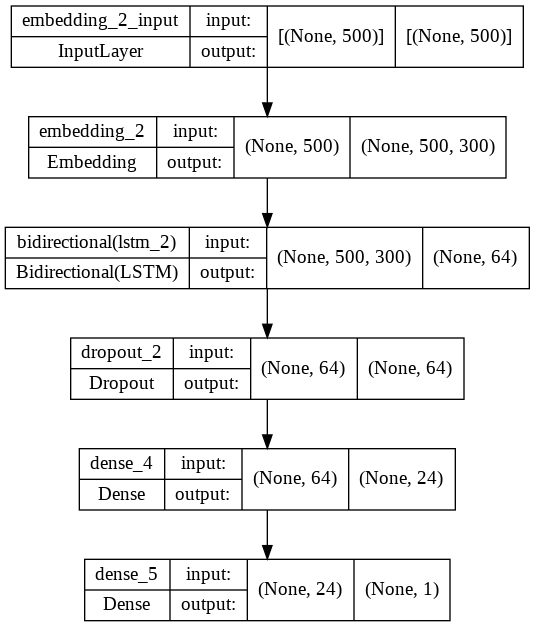

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

Preparing the data for the model in the appropriate form as desired the input layer of the model
1. Tokenizing the training sentences
2. Post Padding

In [ ]:
from keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words = vocab, oov_token = '')
tokenizer.fit_on_texts(train_sents)
word_index = tokenizer.word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sents)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_sents)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [ ]:
train_padded.shape

(37500, 500)

Model Training

In [ ]:
num_epochs = 20
history = model.fit(train_padded[:25000], train_labels[:25000], 
                    epochs=num_epochs, validation_data = ([train_padded[25000:]], [train_labels[25000:]]))

Epoch 1/20
782/782 [==============================] - 613s 778ms/step - loss: 0.4032 - accuracy: 0.8262 - val_loss: 0.3127 - val_accuracy: 0.8722
Epoch 2/20
782/782 [==============================] - 608s 777ms/step - loss: 0.2392 - accuracy: 0.9100 - val_loss: 0.3405 - val_accuracy: 0.8723
Epoch 3/20
782/782 [==============================] - 610s 780ms/step - loss: 0.2150 - accuracy: 0.9191 - val_loss: 0.3388 - val_accuracy: 0.8629
Epoch 4/20
782/782 [==============================] - 602s 770ms/step - loss: 0.1484 - accuracy: 0.9476 - val_loss: 0.3577 - val_accuracy: 0.8595
Epoch 5/20
782/782 [==============================] - 629s 805ms/step - loss: 0.0935 - accuracy: 0.9695 - val_loss: 0.4574 - val_accuracy: 0.8684
Epoch 6/20
782/782 [==============================] - 615s 787ms/step - loss: 0.0768 - accuracy: 0.9763 - val_loss: 0.4886 - val_accuracy: 0.8673
Epoch 7/20
782/782 [==============================] - 626s 800ms/step - loss: 0.0742 - accuracy: 0.9772 - val_loss: 0.5329 -

Time for Results!!

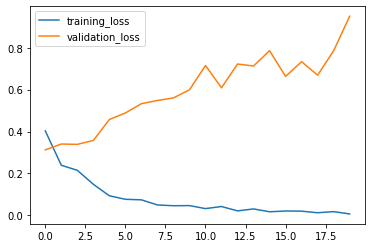

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()

Performance on the test data (the unseen data)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
prediction = model.predict(test_padded)
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(test_labels,pred_labels))


Accuracy of prediction on test set :  0.866


In [ ]:
cf_matrix = confusion_matrix(test_labels, pred_labels)


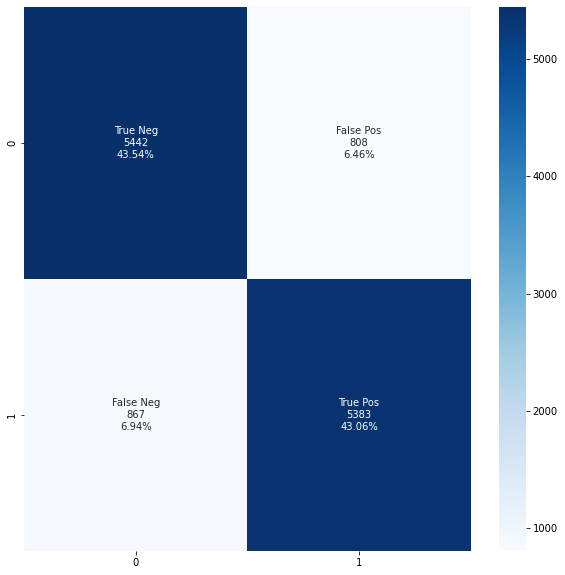

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)


sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
from sklearn.metrics import f1_score
f1_score(test_labels,pred_labels)

0.8653645205369345

In [ ]:
classification_report(test_labels,pred_labels)

'              precision    recall  f1-score   support\n\n           0       0.86      0.87      0.87      6250\n           1       0.87      0.86      0.87      6250\n\n    accuracy                           0.87     12500\n   macro avg       0.87      0.87      0.87     12500\nweighted avg       0.87      0.87      0.87     12500\n'

In [ ]:
""" 
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      6250
           1       0.87      0.86      0.87      6250

    accuracy                           0.87     12500
   macro avg       0.87      0.87      0.87     12500
weighted avg       0.87      0.87      0.87     12500


"""